# The Base-2 Exponential Mechanism

*author: cilvento*

***Abstract***

Despite excellent theoretical support, Differential Privacy (DP) can still be a challenge to implement in practice. In part, this challenge is due to the concerns associated with converting arbitrary or infinite-precision theoretical mechanisms to the reality of floating point or fixed-precision. Beginning with the troubling [result](https://www.microsoft.com/en-us/research/wp-content/uploads/2012/10/lsbs.pdf) of Mironov demonstrating the security issues of using floating point for implementing the Laplace mechanism, there have been many reasonable concerns raised on the vulnerabilities of real-world implementations of DP.

In this work, we examine the practical implementation of the [exponential mechanism](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/mdviadp.pdf) of McSherry and Talwar. (The exponential mechanism can be used to express any DP mechanism, although this is not always the most computationally efficient approach.) We demonstrate that naive or malicious implementations can result in catastrophic privacy failures. To address these problems, we show that the mechanism can be implemented *exactly* for a rich set of values of the privacy parameter $\varepsilon$ and utility functions with limited practical overhead in running time and minimal code complexity. 

How do we achieve this result? We employ a simple trick of switching from base $e$ to base $2$, allowing us to perform precise base 2 arithmetic only converting back to base $e$ to report the *value* of the privacy parameter. A short precise expression is always available for $\varepsilon$, and the only approximation error we incur is the conversion of the base 2 privacy parameter back to base $e$. The core base 2 arithmetic of the mechanism can be simply and efficiently implemented using open-source high precision floating point libraries. Furthermore, the exact nature of the implementation lends itself to simple monitoring of correctness and proofs of privacy.

In this notebook, we demonstrate the base 2 exponential mechanism and vulnerabilities of naive implementations of the exponential mechanism. We also compare running times and mean-squared error of an implementation of the Laplace mechanism using the base 2 exponential mechanism implementation.

## Differential Privacy Background
Differential privacy requires that the outputs of mechanisms operating on private data are stable. That is, they cannot change ``too much'' if a single entry in the input database is changed. A key strength of DP is that it doesn't apply to a single mechanism: any randomized mechanism satisfying the stability requirement is differentially private. 
We give the formal definition below.

**Pure Differential Privacy**:
A randomized mechanism $\mathcal{M}$ is $\varepsilon-$differentially private if for all adjacent databases $d\sim d'$, i.e. databases which differ in a single entry,
$\Pr[\mathcal{M}(d) \in C] \leq e^{\varepsilon}\Pr[\mathcal{M}(d') \in C]$
where probability is taken over the randomness of the mechanism $\mathcal{M}$.


### Known issues with additive noise DP mechanisms
One of the most popular DP mechanisms is the Laplace mechanism, which adds noise drawn from the Laplace distribution scaled to the sensitivity of a function, i.e., how much it can change if a single individual's value changes.

**The Laplace Mechanism**:
Given a function $f:D \rightarrow \mathbb{R}$ with sensitivity $\Delta f:= \max_{d\sim d' \in D}|f(d)-f(d')|$, a privacy parameter $\varepsilon$ and a database $d$, release $f(d)+\tau$ where $\tau$ is drawn
from the sensitivity scaled Laplace distribution, given by probability density $\mathsf{Lap(t|\frac{\Delta f}{\varepsilon})}=\frac{\varepsilon}{2\Delta f}e^{-\frac{\varepsilon |t|}{\Delta f }}$.
The Laplace Mechanism is $\varepsilon-$DP.

Unfortunately, sampling from the Laplace distribution using floating point arithmetic leads to "gaps" in the possible noise values, which, in the right circumstances, can allow an adversary to exactly guess the original value of $f(d)$ from $f(d) + \tau$. Fortunately, there are methods to mitigate this attack by "clamping" the value of $f(d)+\tau$ to prevent gaps, although they require careful implementation.

### The Exponential Mechanism
The [exponential mechanism](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/mdviadp.pdf), proposed by McSherry and Talwar, is a general purpose DP mechanism for releasing arbitrary strings, values or other outputs. For example, suppose a company is trying to set a price for a new piece of software. To set the price, they ask a set of potential buyers the price they are willing to pay, and they promise to keep the prices reported by each potential buyer private and to only release a DP estimate of the optimal price.
The company now has a problem: computing the optimal price and then adding noise may result in a price that \textit{zero} buyers are willing to pay. For example, if all buyers are willing to pay at most $\$10$, setting a price of $\$10.50$ will result in zero sales.
The exponential mechanism handles this problem in an elegant way by assigning a utility score (potential profit) based on the database (the maximum prices) to each potential outcome (each price in a pre-determined range) and then sampling a single outcome based on the utility scores. Using this mechanism, the price of $\$10$ would have very high utility and thus a high probability of selection, whereas any price over $\$10$ would have low utility and probability of selection. In fact, any DP mechanism can be expressed using the exponential mechanism with an appropriately chosen utility function.

**The Exponential Mechanism**:
Given a privacy parameter $\varepsilon$, an outcome set $O$ and a utility function $u: D \times O \rightarrow \mathbb{R}$ which maps (database, outcome) pairs to a real-valued utility, the exponential mechanism samples a single element from $O$ based on the probability distribution
$p(o) := \frac{e^{-\varepsilon u(d, o)}}{\sum_{o \in O} e^{-\varepsilon u(d,o)}}$
If the sensitivity of $u$, $\Delta u := |u(d,o)-u(d',o)| \leq \alpha$ for all adjacent $d,d'$ and for all $o \in O$, then the exponential mechanism is $2\alpha\varepsilon$-DP. 

An initial examination of the exponential mechanism might lead one to imagine that it is immune to the floating point issues of the Laplace mechanism, as no floating point calculation is released directly and the computations of $e^x$ shouldn't have "too much" error. However, we will see below that naive implementations of the exponential mechanism are vulnerable to floating-point based attacks.



### Setup
We rely on GNU Multiple Precision Arithmetic Library ([GMP](https://gmplib.org/) via the [`gmpy2`](https://github.com/aleaxit/gmpy) Python interface for high precision arithmetic and exact arithmetic monitoring in our implementation, as well as some standard libraries (`numpy`, etc).

* Install any libraries needed (gmpy2, etc)
* Standard imports

In [0]:
!apt-get install libgmp-dev
!apt-get install libmpfr-dev
!apt-get install libmpc-dev
!pip install gmpy2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgmpxx4ldbl
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libgmp-dev libgmpxx4ldbl
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 325 kB of archives.
After this operation, 1,667 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgmpxx4ldbl amd64 2:6.1.2+dfsg-2 [8,964 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgmp-dev amd64 2:6.1.2+dfsg-2 [316 kB]
Fetched 325 kB in 1s (258 kB/s)
Selecting previously unselected package libgmpxx4ldbl:amd64.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../libgmpxx4ldbl_2%3a6.1.2+dfsg-2_amd64.deb ...
Unpacking libgmpxx4ldbl:amd64 (2:6.1.2+dfsg-2) ...
Selecting previously unselected package libgmp-dev:amd64

In [0]:
import numpy as np
import gmpy2
from gmpy2 import mpfr, mpz
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import scipy.stats as sk

## The Naive Implementation and Attacks

Although the problems with floating-point implementations of mechanisms like the Laplace mechanism are well documented (see [Mironov](https://www.microsoft.com/en-us/research/wp-content/uploads/2012/10/lsbs.pdf) and related works), the exponential mechanism is vulnerable to a different class of attacks which takes advantage of rounding and truncation properties of floating-point arithmetic. Below, we demonstrate two such attacks using a naive implementation (see `naive.py`) of the exponential mechanism which uses `numpy` for arithmetic operations.

* Attack 1 takes advantage of rounding behavior and chooses a utility function which rounds all weights but one to 0 if a condition is met.
* Attack 2 takes advantage of truncation in addition, and chooses a utility function that always produces positive weights, but the additions are truncated such that some weights are *treated* as if they were zero.


**Note:** to demonstrate these attacks, we construct utility functions which take only the outcome as an argument, as the dependence on the database is simple, and this makes the code easier to read. The utility functions `u1` refer to the case when our target, Alice, is in the database, and `u2` refer to the case when she is not.

In [0]:
from naive import * # Import naive implementation of the exponential mechanism.

### Attack 1


Suppose the attacker wishes to know if Alice is in the database. The attacker designs an outcome space $O=[k]$ and a utility function such that:
* If Alice is in the database $u(o_1)=x$ and the utility for all other outcomes is $x+1$. 
* If Alice is not in the database $u(o_1)=x$ and the utility for all other outcomes is also $x$. 

(By convention $[n]$ indicates the set of integers $\{1,2,\ldots,n\}$. For outcome spaces, we index the elements of $O$ as $o_{i \in [|O|]}$.) 

Notice that the sensitivity of $u$ is $1$ regardless of the choice of $x$. The attacker then sets $x$ such that $\mathtt{np.exp(-(eps/2)x)}>0$ but $\mathtt{np.exp(-(eps/2)(x+1))}=0$. Notice that in the case where Alice is in the database, the only viable outcome is $o_1$, but in the case where Alice is not in the database, all elements have equal (and positive) weight, so a random element will be selected. Thus, the attacker drives has distinguishing probability $\frac{k-1}{k}$ on a single run of the mechanism. 

In [0]:
# Choose constants
k = 100
eps = 0.5

# Find x as described in the attack
x = 0
for i in range(0,4000):
  if np.exp(-(eps/2)*i) == 0:
    x = i-1
    break
print("x =",x) 

# Construct the output space O and two utility functions representing the cases
# for each database
O = [i for i in range(1,k+1)]
u1 = lambda o: x if o == 1 else x+1
u2 = lambda o: x

# Run 100 trials to test the average output in each case
numtrials = 100
u1_outcomes = []
u2_outcomes = []
for i in range(0, numtrials):
  u1_outcomes.append( naive_exp_mech(eps,u1,O))
  u2_outcomes.append(naive_exp_mech(eps,u2,O))
  

print("u1 average: ", np.average(u1_outcomes))
print("u2 average: ", np.average(u2_outcomes))

x = 2980
u1 average:  1.0
u2 average:  49.92


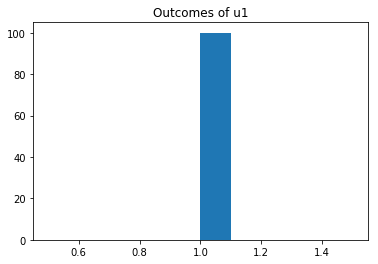

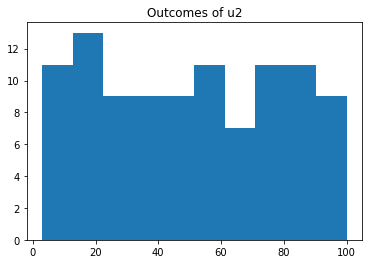

In [0]:
plt.hist(u1_outcomes)
plt.title("Outcomes of u1")
plt.show()
plt.hist(u2_outcomes)
plt.title("Outcomes of u2")
plt.show()

Notice that the average output when Alice is not in the database (`u2`) is significantly different from the average value when Alice is in the database (`u1`), allowing the attacker to easily determine whether or not Alice's data is included. In particular, if Alice is in the database, *no value other than 1 is ever produced*, as illustrated in the output histograms.

### Attack 2


To mitigate Attack 1, one might suggest that we add an assertion that each weight is positive. However, this fix can be subverted by taking advantage of truncated addition. That is, if a very small floating point number is added to a very large floating point number, the addition may result in a no-op if there aren't sufficient bits to express the low order bits of the addition result.

For example:

In [0]:
a = 2**(-30) # a small positive number
b = 2**(30)  # a large positive number
c = a + b    
print(a>0, c==b)  # Despite adding a positive number, the addition is a no-op

True True


Knowing that small, but positive, weights are truncated in addition, the adversary constructs two utilities $x_l$ and $x_s$ and an outcome space $O=[k]$ such that
 $$\mathtt{np.exp(-(eps/2)x_l)} +\sum_{i \in [k]}\mathtt{np.exp(-(eps/2)(x_s+1))}=\mathtt{np.exp(-(eps/2)x_l)}$$ but  $$\mathtt{np.exp(-(eps/2)(x_l+1)) }+\sum_{i \in [k]}\mathtt{np.exp(-(eps/2)(x_s))}\approx \mathtt{2*np.exp(-(eps/2)(x_l+1))}$$ and assigns utility $u(o_1)=x_l+1$
 and assigns $u(o_{i>1})=x_s$ if Alice is in the database and $u(o_1)=x_l$ and $u(o_{i>1})=x_s+1$ if Alice is not in the database. (As before, the sensitivity of $u$ is $1$ regardless of the choice of $x_s,x_l$. Notice that if Alice is in the database, the only viable outcome is $o_1$, but if she is not, then $o_1$ is chosen only about half of the time. (Note: of course the adversary could tip the scales further in their favor by increasing $k$.) 

In [0]:
eps = 30 # Note: we choose a large epsilon to limit the amount of time searching the space.
y = -0.5
print("y:",y)
ey = np.exp(-(eps/2)*y)
#print(ey)
for x in range(0,5000):
  if (np.exp(-(eps/2)*x) + ey) == ey and np.exp(-(eps/2)*x) > 0:
    break

print("x:", x)#, np.exp(-(eps/2)*x) )
#print(np.exp(-(eps/2)*x) + ey, ey)
u1 = lambda o: y if o == 1 else x
u2 = lambda o: y+1 if o==1 else x-1 

s = np.exp(-(eps/2)*(y+1))
t = np.exp(-(eps/2)*(x-1))
total = s
for k in range(1000,10000):
  ratio = t*k/s 
  if ratio > 1/10:
    print("k:",k)
    break
O = [i for i in range(0,k)]

# Run several trials to see difference in outcomes.
numtrials = 100
u1_outcomes = []
u2_outcomes = []
for i in range(0, numtrials):
  u1_outcomes.append(naive_exp_mech(eps,u1,O))
  u2_outcomes.append(naive_exp_mech(eps,u2,O))
  

print("u1 average: ", np.average(u1_outcomes))
print("u2 average: ", np.average(u2_outcomes))

y: -0.5
x: 2
k: 1000
u1 average:  1.0
u2 average:  208.76


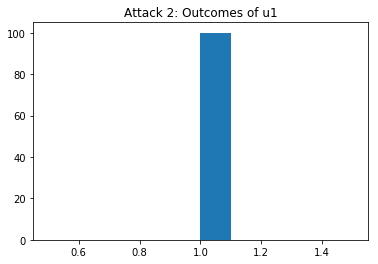

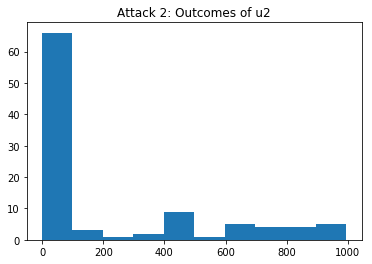

In [0]:
plt.hist(u1_outcomes)
plt.title("Attack 2: Outcomes of u1")
plt.show()
plt.hist(u2_outcomes)
plt.title("Attack 2: Outcomes of u2")
plt.show()

Notice that once again, if Alice is in the database, that the only possible output is 1, whereas if Alice is not in the database, a variety of outcomes in $[0,10]$ may be produced. Although the difference is not as dramatic as in Attack 1, this vulnerability can still be exploited by a determined adversary.

### Issues with mitigating floating point attacks on inexact arithmetic

The troubling property of Attack 2 is that all weights are positive, and one would need to monitor the outcome of each addition in the mechanism to ensure that values are not excessively truncated to try to catch such subversion. However, such monitoring is non-trivial as the additions are not expected to be exactly correct as $e^x$ cannot be expressed exactly in a finite number of bits.
One approach is to clamp the allowed utilities to a range in which we can compute additions of the smallest and largest possible weights safely. But how do we decide on such a range, and what is the impact of the inexact computations on privacy (given the vagaries of floating point *division* for weight normalization as well as addition and approximate computations of `np.exp`)?


The key problem with declaring a certain range of utilities to be safe is the difficulty in characterizing the privacy loss due to inexact arithmetic. For example, suppose that a range was chosen which has a maximum error on the order of $2^{-k}$. If each individual weight and the total weights are on the order of $2^0$, this error may be negligible from a privacy perspective, but if each individual weight is on the order of $2^{-k}$, it is not. Thus any general guarantee we might give on the privacy loss of the implementation must be pessimistic.
Furthermore, the more involved and complete the defenses for such attacks become, the more complicated and difficult to audit the code becomes, increasing the likelihood of errors and those errors being missed under audit. At the risk of belaboring the point, we also note that the number of bits of precision for built in types in certain languages can be set by the compiler further increasing the difficulty of effective auditing.

## The Base-2 Exponential Mechanism
To mitigate these problems, we propose thinking about DP in base $2$ rather than base $e$, which translates to a simple change of base:
$\Pr[\mathcal{M}(d) \in C] \leq 2^{\eta}\Pr[\mathcal{M}(d') \in C]$ from
$\Pr[\mathcal{M}(d) \in C] \leq e^{\ln(2)\eta}\Pr[\mathcal{M}(d') \in C]$. 

With this change of perspective, we can rewrite the probability distribution of  exponential mechanism in base 2 as 
$p(o) := \frac{2^{-\eta u(d, o)}}{\sum_{o \in O} 2^{-\eta u(d,o)}}$.

The benefit of this change is that we now have a path to implementing the exponential mechanism *exactly* rather than allowing floating point errors to creep in. Exact arithmetic also allows for more straightforward monitoring of correctness and thus privacy. 
Although the logic of the implementation is nearly identical to the naive version, showing that the base-2 exponential mechanism can be implemented exactly is not quite as trivial as swapping `np.exp` for `2**x`.
There are several components of the implementation and mechanism design:
1. Allowing expressive privacy parameters: we show that taking $\eta \in \{-z\log(\frac{x}{2^y})\}$ for integer $x$, $y$ and $z$ such that $\frac{x}{2^y}<1$ results in an expressive set of privacy parameters such that $2^{-\eta}$ can be computed exactly with limited precision.
2. Handling non-integer utilities via randomized rounding: we show that randomized rounding, i.e. rounding up with probability $p = x - \lfloor{x}\rfloor$ and down with probability $1-p$ does not hurt privacy. This allows us to run the mechanism with integer utilities, which makes computing $2^{-\eta u(d,o)}$ simple.
3. Sampling without division: we give a simple method for sampling with normalized probabilities (i.e. $\frac{1}{\sum_{o \in O} 2^{-\eta u(d,o)}}$) that doesn't require division.
See **paper** for complete descriptions of the mechanisms and analysis. 

### Implementation 
The base-2 exponential mechanism uses the [`gmpy2`](https://github.com/aleaxit/gmpy) interface to the GNU Multiple Precision Arithmetic Library ([GMP](https://gmplib.org/)) for high-precision binary arithmetic.  See `expmech.py` for code and additional documentation.




In [0]:
# Example usage

from expmech import *

# Initialize outcomes and utilities
u = lambda x : abs(0 - x) # Laplace distribution utility centered at 0

# privacy parameters
eta_y = 1
eta_x = 1
eta = -np.log2((eta_x/(2**eta_y)))
eps = 2*np.log(2)*(-np.log2((eta_x/(2**eta_y))))
print("eta = ", eta, "epsilon = ",eps)

# outcome space
gamma = 2**(-4)
k = 160
O = [i*gamma for i in range(-k,k+1)]

# random bit generator
rng = lambda : np.random.randint(0,2) # np.random is a placeholder for demonstration purposes only

# Initialize the mechanism
e = ExpMech(rng,eta_x=eta_x,eta_y=eta_y,eta_z=1,u_min=(O[0]*2),u_max=0,max_O=len(O))

# set the utility function
e.set_utility(u)

# run the mechanism
result = e.exact_exp_mech(O)
print("result:", result)

eta =  1.0 epsilon =  1.3862943611198906
result: 7.1875


The base-2 exponential mechanism can also be used to simulate drawing from the Laplace distribution or implementing the discretized Laplace mechanism. We implement the Laplace mechanism as a child class of the Exponential mechanism, which simplifies the semantics significantly.

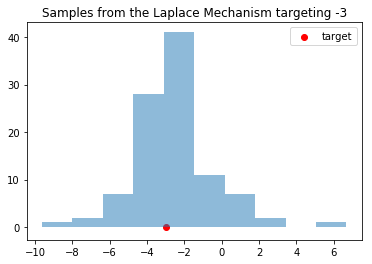

In [0]:
b_min = -10 # the range of outputs [-10,10] at granularity 2^-4
b_max = 10
gamma = 2**(-4)
eta_z = 1
s = 1 # the sensitivity of the function
t = np.random.randint(b_min,b_max) # select a random "target" value in the range
l = LaplaceMech(rng, t, s, eta_x, eta_y, eta_z, b_min,b_max,gamma)
n = 100
samples = []
for i in range(0,n):
  samples.append(l.run_mechanism())
plt.hist(samples,bins=int(n/10),alpha=0.5)
plt.scatter(t,0,marker='o',color='r',label='target')
plt.legend()
plt.title("Samples from the Laplace Mechanism targeting "+str(t))
plt.show()

### Performance of base-2 vs naive implementation
The key question we must address other than privacy is the performance of our mechanism. To demonstrate the difference (in fact, lack of difference) in running time and output distribution of the naive exponential mechanism versus the base-2 exponential mechanism, we use both to simulate the Laplace distribution centered at $0$ and clamped between $[-k\gamma,k\gamma]$ with the output range set at granularity $\gamma$. (Note: one can think of the Laplace mechanism as an infinite outcome space instantiation of the exponential mechanism. See the **paper** for more details.)

**Note:** the base-2 mechanism expects the input $\eta$ to be adjusted such that $\eta \ln(2) = \frac{\varepsilon}{2}$.

First, we show a comparison between the distributions output by the naive implementation of the Laplace mechanism and the base-2 mechanism, which includes randomized rounding.

In [0]:
# Get n samples from each of the mechanisms
n = 1000
util = lambda x : abs(x - t) # Laplace distribution utility
O = l.Outcomes
b2_results = []
naive_results = []
for i in range(0,n):
  b2_results.append(l.run_mechanism())
  naive_results.append(naive_exp_mech(eps,util,O))

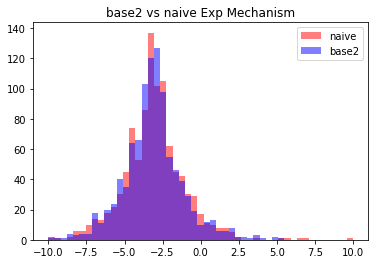

In [0]:
# Plot the samples in a histogram
bin_set = np.linspace(-10,10,50)
plt.hist(naive_results,bins=bin_set,color='r', alpha = 0.5, label='naive')
plt.hist(b2_results,bins=bin_set, color='b', alpha = 0.5, label='base2')
plt.legend()
plt.title("base2 vs naive Exp Mechanism")
plt.show()


Another way of comparing the distributions is the [KS statistic](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), which tests if two distributions are different. In this case, the KS statistic is small, and the p-value large, so we cannot reject the null hypothesis that the distributions are the same.

In [0]:
sk.ks_2samp(b2_results,naive_results)

Ks_2sampResult(statistic=0.042, pvalue=0.34112475112661245)

#### Theoretical error bounds
The difference between the probability distribution of the base-2 mechanism, which uses randomized rounding to guarantee integer utilities, and the un-rounded naive mechanism can also be compared by upper and lower-bounding the probability assigned to each outcome by randomized rounding. Below, we plot a conservative theoretical estimate of the maximum point-wise error on the probability assigned to any given element by the randomized rounding base-2 mechanism compared with the naive mechanism. The maximum error decreases as the granularity increases (smaller $\gamma$). (See **paper** and `accuracy_comparison.py` for more details).

![maximum pointwise error](https://drive.google.com/uc?id=1JLaBfCMOjQnkdZj57xlAuuEW3E6-118j)

#### Running Time
With respect to performance, the base-2 mechanism is comparable to the naive mechanism as the number of elements in the output space increases. However, as the range of utilities grows, the base-2 mechanism performs worse than the naive mechanism, as it scales precision to handle a wider range of utilities accurately. Below, we compare timing between running the Laplace mechanism at increasing granularity (more outputs, but the same utility range) versus a discrete output task with increasing utility range and a discrete output task with increasing utility range (but fixed outcome set size) to illustrate these differences . 

![discrete timing](https://drive.google.com/uc?id=1TsBnZSFRNI-NO2CDJcxDVIBWkNb3tvQP) As the outcome range and utility range increase, the performance of the base-2 mechanism degrades compared with the naive implementation, as it requires higher precision.

![utility timing](https://drive.google.com/uc?id=1CQ2y-7w1ooPBjNtC4rmXQ5t8Wq5tZ6vv) Fixing the size of the outcome space and only varying the range of allowed utilties, the difference in performance due to increase precision is clear.

![laplace timing](https://drive.google.com/uc?id=1inw6S5cfRlzT8Dnr2b2xFMJbiBmsm8S5) Note that smaller $\gamma$ indicates increased granularity and therefore a larger outcome space.

Although the performance of the base-2 mechanism is impacted by the increased precision, we do note that it is possible to run the mechanism on tens of thousands of possible outcomes with a discrete utility range from $[0, 20000]$ in about twenty minutes on Google's Colaboratory free tier.
![extended timing](https://drive.google.com/uc?id=1KN90pfyePe8rC96VUx_ZpkJgiC67ppFZ)

### Base-2 vs numpy Laplace distribution
Of course, if we wish to use the base-2 exponential mechanism to implement the Laplace mechanism, it is also relevant to test against the (vulnerable) implementation of the Laplace distribution provided in `numpy`. In these cases, the running time of the base-2 mechanism or the naive exponential mechanism is significantly slower than the `numpy` version. However, the base-2 mechanism still closely approximates the target distribution.


In [0]:
# Get n samples from the numpy laplace implementation
f = lambda : t
numpy_results =  [naive_laplace(f,1.0,eps) for i in range(0,n)]


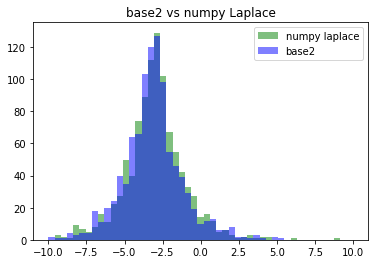

In [0]:
plt.hist(numpy_results,bins=bin_set,color='g', alpha = 0.5, label='numpy laplace')
plt.hist(b2_results,bins=bin_set, color='b', alpha = 0.5, label='base2')
plt.legend()
plt.title("base2 vs numpy Laplace")
plt.show()